## Application: Labor Participation
---

#### Variables:

+ work - participation in 1975 ? (error: "no" must be "yes")
+ hoursw - wife's hours of work in 1975
+ child6 - number of children less than 6 years old in household
+ child618 - number of children between ages 6 and 18 in household
+ agew - wife's age
+ educw - wife's educational attainment, in years
+ hearnw - wife's average hourly earnings, in 1975 dollars
+ wagew - wife's wage reported at the time of the 1976 interview (not= 1975 estimated wage)
+ hoursh - husband's hours worked in 1975
+ ageh - husband's age
+ educh - husband's educational attainment, in years
+ wageh - husband's wage, in 1975 dollars
+ income - family income, in 1975 dollars
+ educwm - wife's mother's educational attainment, in years
+ educwf - wife's father's educational attainment, in years
+ unemprate - unemployment rate in county of residence, in percentage points
+ city - lives in large city (SMSA) ?
+ experience - actual years of wife's previous labor market experience

#### Source:

Mroz - Labor Supply Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

Mroz, T. (1987) “The sensitivity of an empirical model of married women's hours of work to economic and statistical assumptions”, Econometrica, 55, 765-799.


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import datasets
import pymc3 as pm
import arviz as az
from IPython.display import display

#### Labor participation

$$
 y_i = \begin{cases} 1, & \text{not work}; \\ 0, & \text{work}. \end{cases}
$$

$$
 \log\frac{\mu}{1-\mu}
 = \text{constant}
 + \beta_1(\text{hoursh}\times\text{wageh}\div 1000)
 + \beta_2\text{univ}
 + \beta_3\text{city}
 + \beta_4\text{experience}
 + \beta_5\text{child6}
 + \beta_6\text{unemprate}
$$

where

$$
 \text{univ} = \begin{cases} 1, & \text{university gradaute or higher};\\ 0, & \text{otherwise}. \end{cases}.
$$


In [2]:
mroz = datasets.get_rdataset('Mroz', 'Ecdat')
data = mroz.data
earnings = data['hoursh'].values * data['wageh'].values / 1000
age = data['agew'].values
dummy_univ = (data['educw'].values >= 16)
dummy_city = data['city'].replace(['yes', 'no'], [1, 0]).values
y = data['work'].replace(['yes', 'no'], [0, 1]).values
X = np.hstack((np.vstack((np.ones(y.size), earnings, dummy_univ, dummy_city)).T,
              data[['experience', 'child6', 'unemprate']].values))
var_names = ['constant', 'earnings', 'university', 'city', 'experience', 'child6', 'unemprate']

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
logit_model = pm.Model()
with logit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', logit_p=idx, observed=y)
n_draws = 5000
n_chains = 4
n_tune = 1000
with logit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123, return_inferencedata=False)
    results = az.summary(trace)
results.index = var_names
sim_param = dict([(var, trace['b'][:, index]) for index, var in enumerate(var_names)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 34 seconds.


In [4]:
display(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,0.071,0.301,-0.518,0.621,0.002,0.002,15987.0,13081.0,1.0
earnings,0.022,0.010,0.004,0.041,0.000,0.000,20191.0,13919.0,1.0
university,-1.264,0.275,-1.766,-0.739,0.002,0.001,21212.0,13541.0,1.0
city,0.004,0.182,-0.341,0.349,0.001,0.001,21406.0,14563.0,1.0
experience,-0.095,0.012,-0.118,-0.072,0.000,0.000,21252.0,14529.0,1.0
child6,0.762,0.167,0.448,1.076,0.001,0.001,23000.0,14663.0,1.0
unemprate,0.024,0.027,-0.026,0.075,0.000,0.000,17925.0,13165.0,1.0


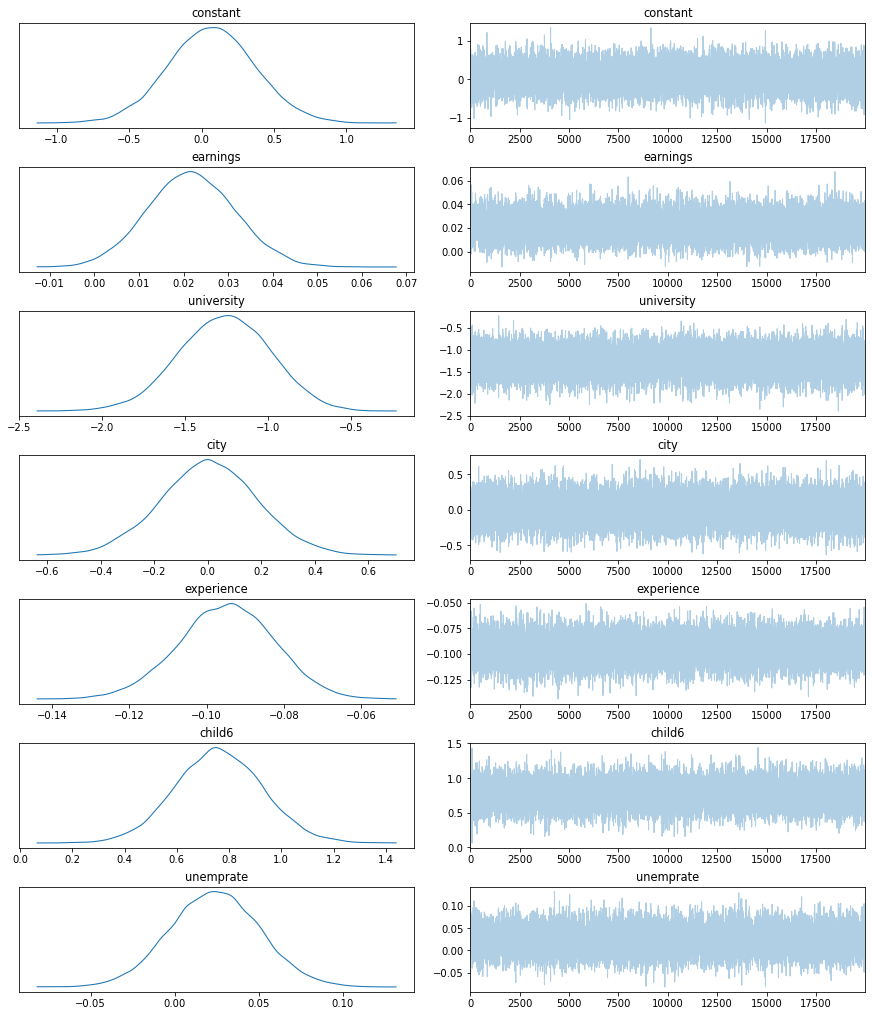

In [5]:
az.plot_trace(sim_param)
plt.show()

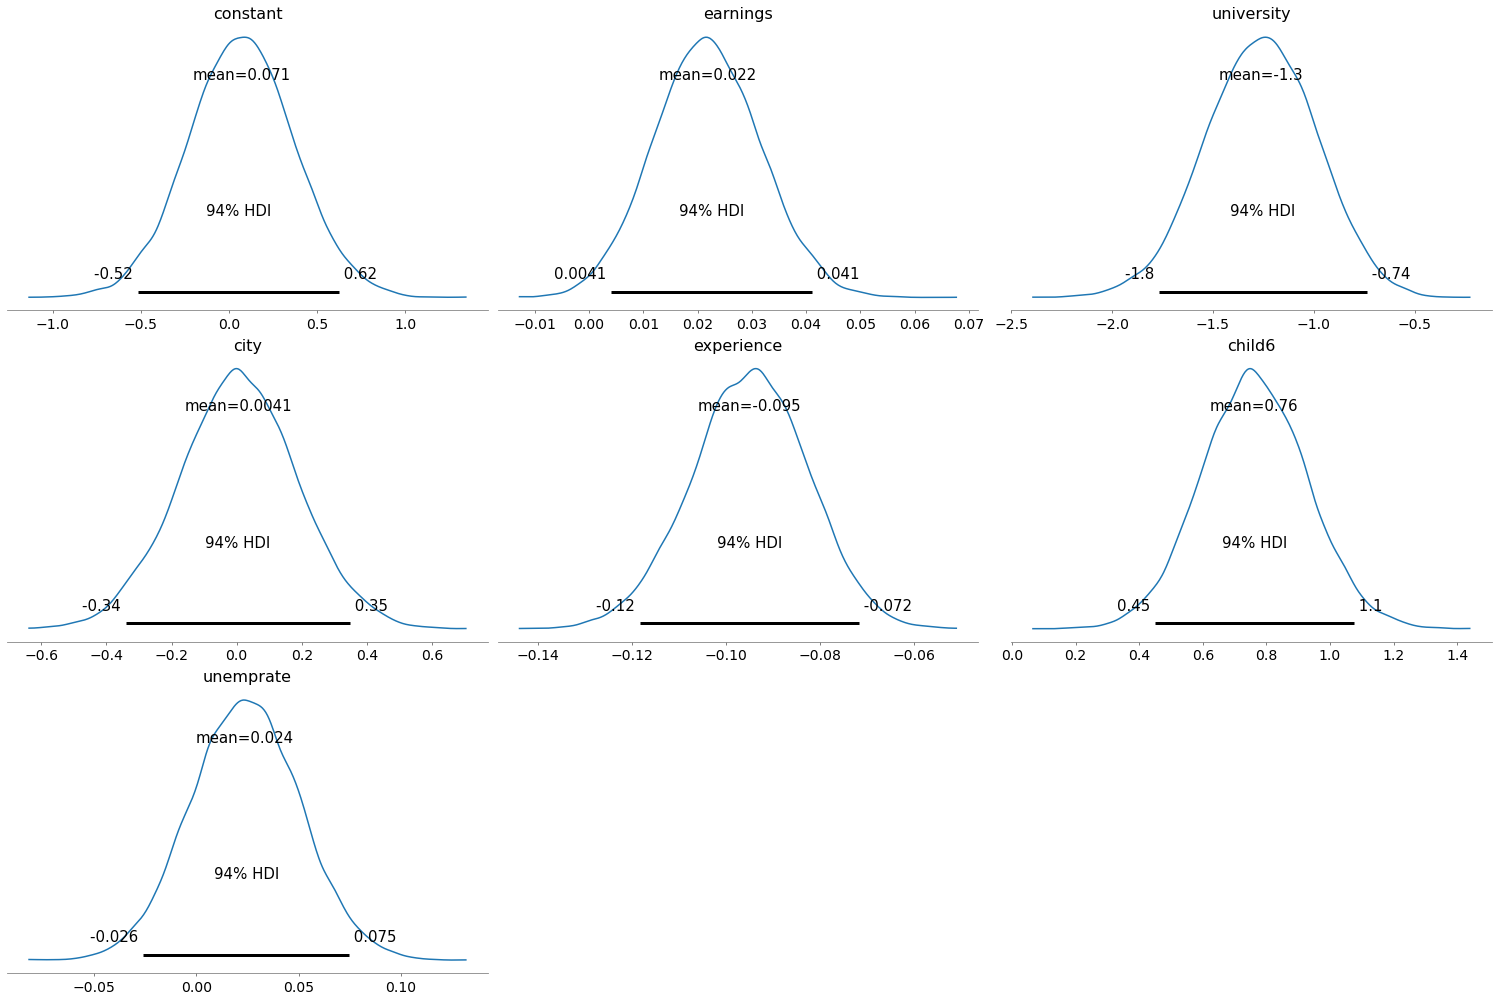

In [6]:
az.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.show()